In [3]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import mlx.core as mx
mx.enable_compile()

from matplotlib import rcParams
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_rgb, LightSource, PowerNorm

%config InlineBackend.figure_format = 'retina'

## Particle Lenia
Inspired by https://google-research.github.io/self-organising-systems/particle-lenia/

$$ \frac{d\mathbf{x}_i}{dt} = -∇E(\mathbf{x}_i) \qquad \mathbf{x}_i \in ℝ ^2 \qquad i = 1...N$$

$$ E(\mathbf{x})=R(\mathbf{x})-G(\mathbf{x})= \frac{c_\text{rep}}{2}\sum_{i: \mathbf{x}_i \neq \mathbf{x}} \max\big(1-\Vert \mathbf{x} - \mathbf{x}_i\Vert,\; 0\big)^2 - G(U(\mathbf{x}))$$

$$ U(\mathbf{x}) = \sum_i K\big(\Vert\mathbf{x}-\mathbf{x}_i\Vert\big)$$

$$ K(r) = w_K\exp\big({-(r-\mu_K)^2 \big/ \sigma_K^2}\big) $$

$$ G(u) = \exp\big({-(u-\mu_G)^2 \big/ \sigma_G^2}\big) $$

Parameters are:

- $N$: number of particles,
- $c_\text{rep}$: repulsion strength,
- $\mu_K$, $\sigma_K$, $w_K$: particle kernel representation,
- $\mu_G$, $\sigma_G$: growth field parameters.

In [4]:
#utility functions and definitions
def norm(v, axis=-1, keepdims=False, eps=0.0):
    """
    Compute the norm of a vector, with an option to add a small epsilon to avoid division by zero.

    Parameters:
    - v: Input vector.
    - axis (int, optional): Axis along which to compute the vector norms. Default is -1.
    - keepdims (bool, optional): Whether to keep the dimensions of the original array. Default is False.
    - eps (float, optional): A small number added to the norm to avoid division by zero. Default is 0.0.

    Returns:
    - The norm of the vector, possibly with added epsilon, depending on the input parameters.
    """
    return mx.sqrt((v*v).sum(axis, keepdims=keepdims).clip(eps))

def normalize(v, axis=-1, eps=1e-20):
    """
    Normalize a vector by its norm, with an option to add a small epsilon to avoid division by zero.

    Parameters:
    - v: Input vector.
    - axis (int, optional): Axis along which to normalize the vector. Default is -1.
    - eps (float, optional): A small number added to avoid division by zero. Default is 1e-20.

    Returns:
    - The normalized vector.
    """
    return v/norm(v, axis, keepdims=True, eps=eps)

def peak_f(x, mu, sigma, a):
    """
    Compute the value of a Gaussian (bell-shaped) function with given parameters.

    Parameters:
    - x: The input value(s) at which to evaluate the peak function.
    - mu: The mean or "center" of the peak function.
    - sigma: The standard deviation, controlling the width of the peak.
    - a: The amplitude of the peak.

    Returns:
    - The value of the peak function at x.
    """
    return a*mx.exp(-((x-mu)/sigma)**2)

"""
A named tuple for model parameters.

Attributes:
- mu_k, sigma_k, w_k: Parameters for the kernel peak function.
- mu_g, sigma_g: Parameters for the gradient peak function.
- c_rep: Repulsion coefficient.
"""
Params = namedtuple('Params', 'mu_k sigma_k w_k mu_g sigma_g c_rep')


"""
A named tuple for field values calculated at a point.

Attributes:
- U: Potential field.
- G: Gradient of the potential field.
- R: Repulsion field.
- E: Energy, defined as the difference between the repulsion and gradient fields.
"""
Fields = namedtuple('Fields', 'U G R E')

In [10]:
class ParticleLenia():
    def __init__(self, p: Params, initial_coordinates):
        """
        Initialize the Particle Lenia model with given parameters and initial coordinates.

        Parameters:
        - p (Params): An object of type Params containing the parameters of the model such as mu_k, sigma_k, w_k for the peak function, 
                      and mu_g, sigma_g, c_rep for the fields calculation. mu_k, sigma_k, and w_k could be arrays.
        - initial_coordinates: Initial positions of the particles in the model, expected to be a Numpy array or similar data structure 
                               that supports vectorized operations.

        Attributes:
        - params (Params): Model parameters.
        - points0: Initial coordinates of the particles.
        - history (list): A list to record the history of particles' coordinates over time.
        """
        self.params = p
        self.points0 = initial_coordinates
        self.history = [initial_coordinates]
        
    def fields_f(self, points, x):
        """
        Calculate the fields at a given point x based on the positions of all other points.

        Parameters:
        - points: Current positions of all particles.
        - x: The point at which to calculate the fields.

        Returns:
        - Fields: An object of type Fields containing the calculated field values U (potential), G (gradient), 
                  R (repulsion), and E (energy difference).

        The calculation uses the model parameters to compute the interaction between particles.
        """
        r = mx.sqrt(mx.clip(mx.square(x-points).sum(axis=-1), 1e-10, None))
        U = peak_f(r, self.params.mu_k, self.params.sigma_k, self.params.w_k).sum()
        G = peak_f(U, self.params.mu_g, self.params.sigma_g, 1.)
        R = (self.params.c_rep/2 * mx.clip(1.0-r, 0.0, None)**2).sum()
        return Fields(U, G, R, E=R-G)

    def field_x(self, points):
        """
        Vectorized mapping of fields_f over an array of points.

        Parameters:
        - points: Current positions of all particles.

        Returns:
        - A vectorized map object that applies fields_f function over an array of points, 
          calculating the fields for each point.
        """
        return mx.vmap(lambda x : self.fields_f(points, x))
    
    def motion_f(self, points):
        """
        Calculate the motion function for the particles based on the gradient of the energy.

        Parameters:
        - points: Current positions of all particles.

        Returns:
        - A vectorized map object that applies the gradient of the energy field to calculate 
          the motion direction and magnitude for each particle.
        """
        grad_E = mx.grad(lambda x : self.fields_f(points, x).E)
        return mx.vmap(grad_E)

    def odeint_euler(self, dt, n):
        """
        Simulate the model's evolution over time using Euler's method for numerical integration.

        Parameters:
        - dt (float): Time step for the simulation.
        - n (int): Number of steps to simulate.

        The method updates the history attribute with the new coordinates of the particles 
        after each step. It prints the simulation progress and parameters at the start, 
        at every 2000th step, and at the end.
        """
        def step_f(x):
            x = x-dt*self.motion_f(x)(x)
            mx.eval(x)
            return x
        
        print(f"Starting simulation with params {self.params}")
        for i in range(1, n):
            self.history.append(step_f(self.history[-1]))
            if i%2000==0:
                print(f"Step {i}")
        print(f"Ending simulation with params {self.params} \n")

In [11]:
dt = 0.1
key = mx.random.key(20) #20

n_particles = 400
params = Params(mu_k=2.75, sigma_k=1.25, w_k=0.02625, mu_g=0.7, sigma_g=0.16666666666666669, c_rep=1.0)
points0 = mx.random.uniform(-6.,6., [n_particles, 2])
pl = ParticleLenia(params, points0)

In [12]:
pl.odeint_euler(dt, 100)

Starting simulation with params Params(mu_k=2.75, sigma_k=1.25, w_k=0.02625, mu_g=0.7, sigma_g=0.16666666666666669, c_rep=1.0)
Ending simulation with params Params(mu_k=2.75, sigma_k=1.25, w_k=0.02625, mu_g=0.7, sigma_g=0.16666666666666669, c_rep=1.0) 



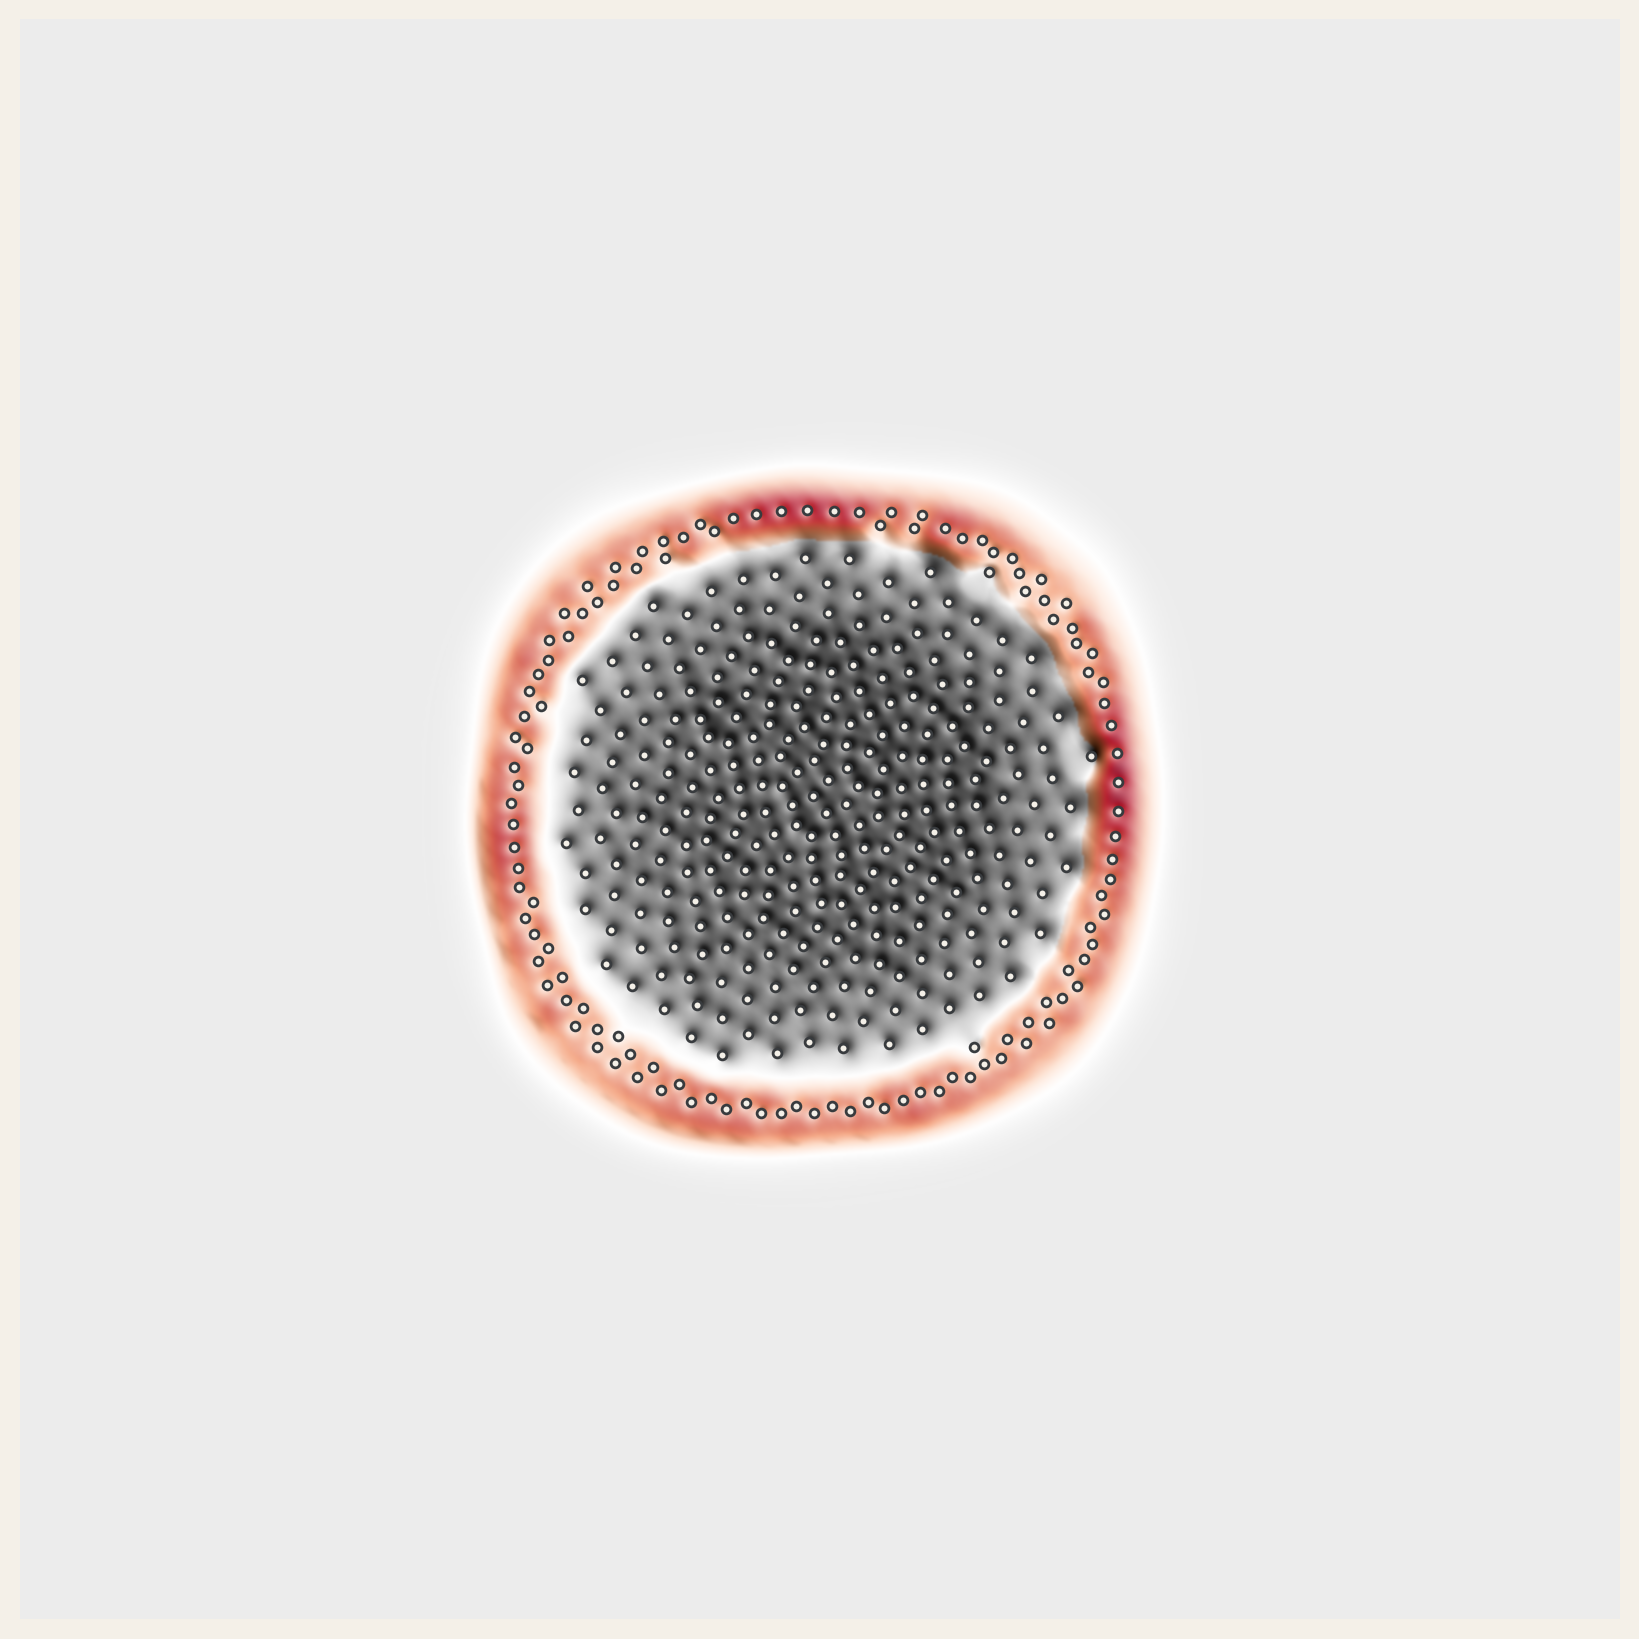

In [14]:
size = [-22,22,800]
index = -1
grid_x, grid_y = np.meshgrid(np.linspace(*size), np.linspace(*size))
grid = np.array([grid_x.reshape(-1), grid_y.reshape(-1)]).T
grid = mx.array(grid)

E_field = pl.field_x(pl.history[index])(grid)[3].reshape((size[-1],-1))

fig, ax = plt.subplots(figsize=(8,8))
fig.set_facecolor("#f4f0e8")
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ax.set_facecolor("#f4f0e8") 
ls = LightSource(azdeg=315, altdeg=45)
ax.scatter(pl.history[index][:,0], pl.history[index][:,1], edgecolors="#383b3e", c="#f4f0e8", s=10, linewidths=1)
E_field_shaded = ls.shade(np.array(E_field), cmap=plt.cm.RdGy, vert_exag=4, blend_mode='hsv', vmin=-0.7, vmax=0.5)
ax.imshow(E_field_shaded, extent=(size[0], size[1], size[0], size[1]),
          origin="lower", interpolation="bicubic")

ax.set_aspect('equal', 'box')
ax.set_axis_off()
ax.set_xlim([-22, 22])
ax.set_ylim([-22, 22])
plt.show() 